<a href="https://colab.research.google.com/github/itzelgabrielaroquedelgado076-cell/Estad-stica2025B/blob/main/MSFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar dataframe si YF da error

In [91]:
pip install alpha_vantage

In [92]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Entra a https://www.alphavantage.co/support/#api-key
# Registrate para obtener tu api-key

# Tu clave de API (reemplaza esta por la tuya)
my_key = 'I1NS9BW0F8UZF8V0'   # esta es mía, no la uses o habrá problemas

# Crear objeto TimeSeries
ts = TimeSeries(key=my_key, output_format='pandas')

# Obtener datos diarios de AMZN
# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener
ticker = 'MSFT' # microsoft
data, meta = ts.get_daily(symbol=ticker, outputsize='full')

columnas = [ticker + '_' + i for i in ['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = columnas

# YYYY-mm-dd
inicio = '2023-07-20'
fin = '2025-11-11'
df = data[(data.index >= inicio) & (data.index <= fin)]

df

,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume
date,,,,,
2025-11-11,504.800,509.600,502.3488,508.68,17980020.0
2025-11-10,500.035,506.850,498.8000,506.00,26101480.0
2025-11-07,496.945,499.377,493.2500,496.82,24019764.0
2025-11-06,505.660,505.700,495.8100,497.10,27406496.0
2025-11-05,513.300,514.830,506.5750,507.16,22883851.0
...,...,...,...,...,...
2023-07-26,341.440,344.670,333.1100,337.77,58383702.0
2023-07-25,347.110,351.890,345.0700,350.98,41637739.0
2023-07-24,345.850,346.920,342.3100,345.11,26719207.0


#Medias móviles

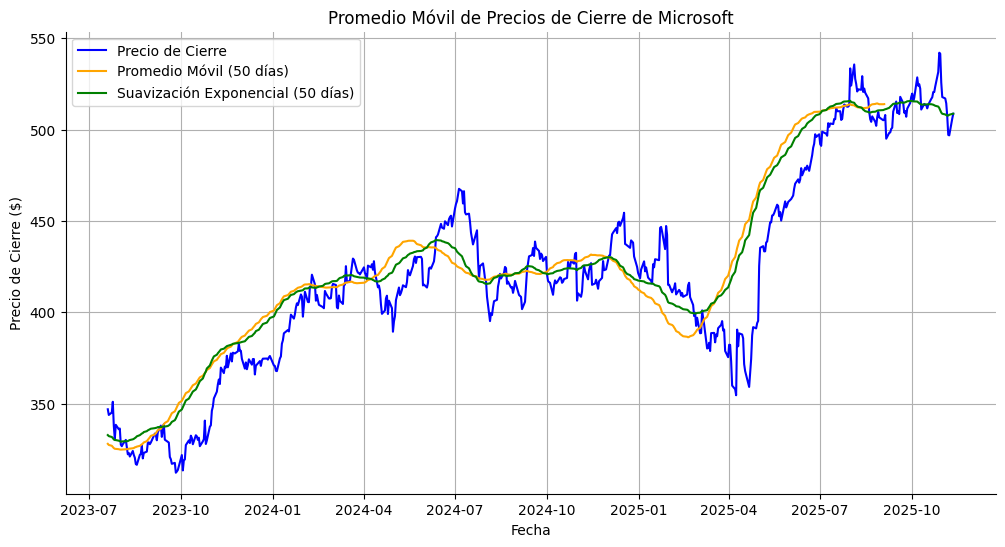

In [93]:
# Promedio Móvil Simple
ventana_sma = 50
df['SMA'] = df['MSFT_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 50
df['SES'] = df['MSFT_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['MSFT_Close'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title('Promedio Móvil de Precios de Cierre de Microsoft')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

#Parte (b)

# Prueba Dickey-Fuller Aumentada

---



In [94]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['MSFT_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")


Estadístico ADF: -1.317967870355434
p-value: 0.6209124284379931
La tendencia no es estacionaria (aceptamos la hipótesis nula).


CONCLUSIÓN:

La prueba ADF nos permite verificar si una serie de tiempo es estacionaria o no estacionaria. En este caso, se puedo determinar que la serie del precio de cierre de Microsoft no es estacionaria debido a que el valor-p obtenido de 0.629124 es mayor al nivel de significacia de 0.05, lo que nos indica que no se rechaza la hipótesis nula, lo que significa que los precios de cierre de esta marca no tienen un comportamiento estable en el tiempo ya que estos van cambiando y siguen una tendencia lo cual es algo que se puede observar visualmente en el gráfico previo a esta prueba.  

#Parte (c)

# Regresión polinomial

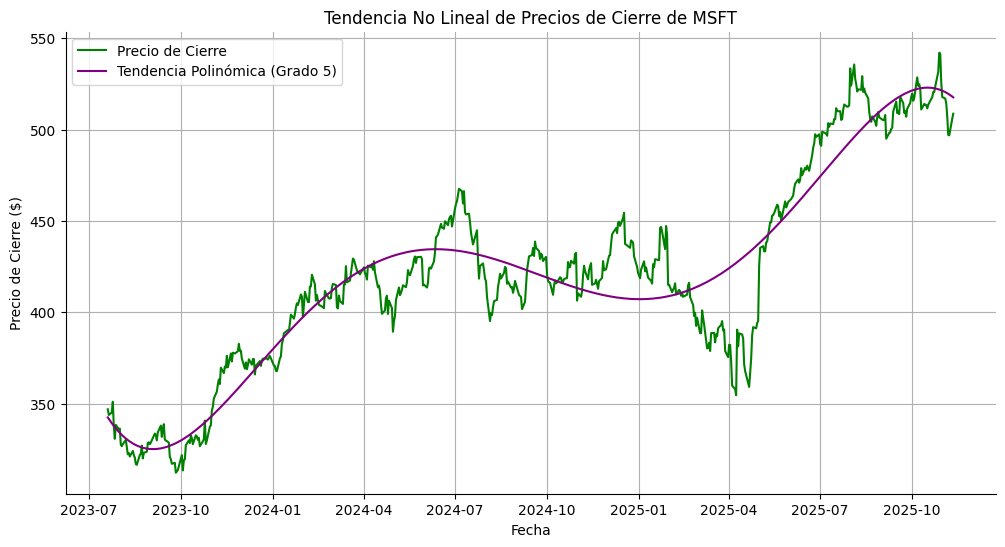

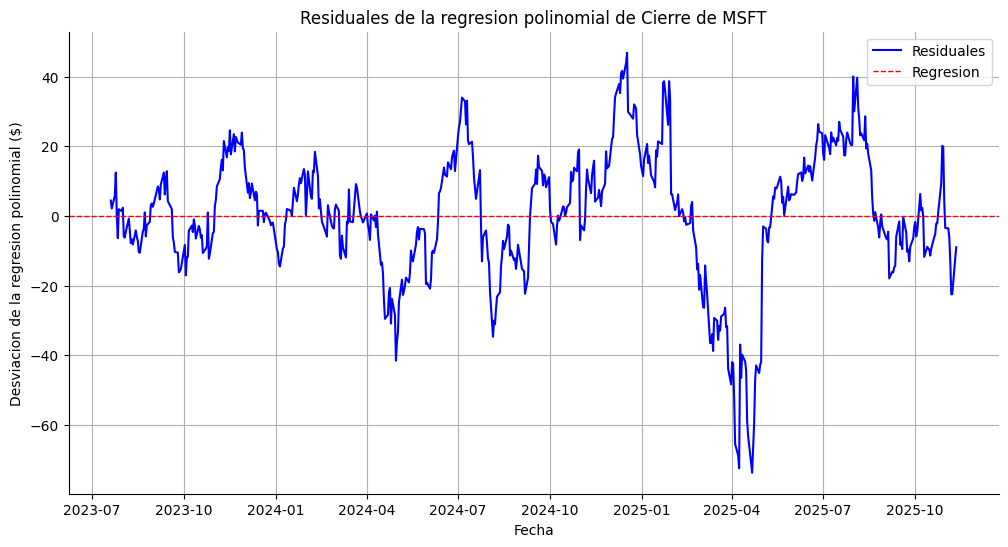

In [95]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['MSFT_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 5
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de MSFT') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de MSFT')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Para Pros: Series de Fourier

In [96]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico, termino):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal
      if i == termino:
          df["seasonal_poly"] = componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='red')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

Frecuencias principales:
    frecuencia     magnitud  longitud_de_onda
0    0.008591  3435.041844        116.400000
1    0.006873  3408.945063        145.500000
2    0.005155  3283.227503        194.000000
3    0.018900  1993.614799         52.909091
4    0.013746  1723.482042         72.750000


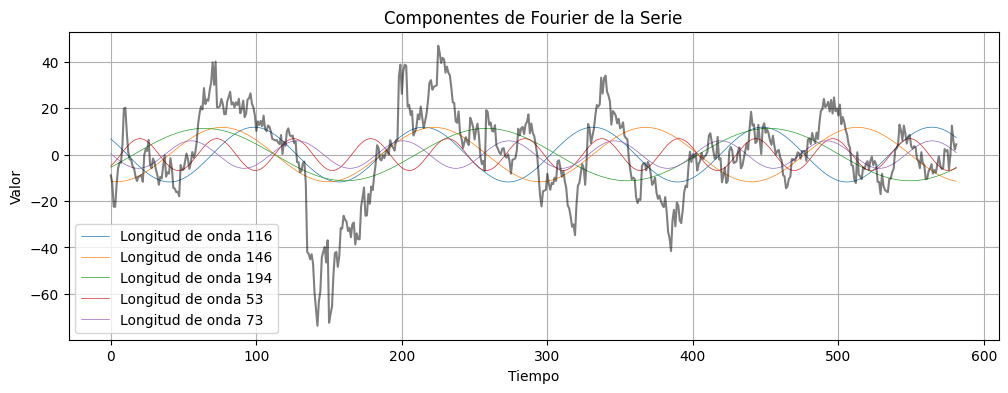

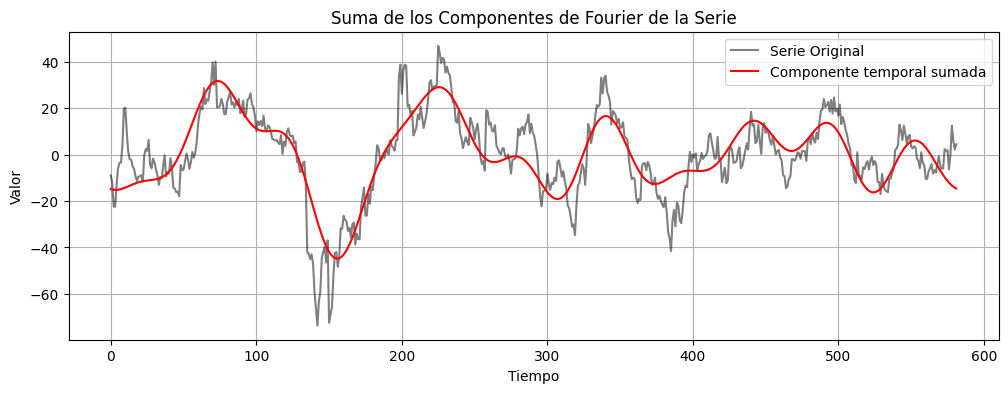

In [97]:
serie = df['Poly_Resid'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico, 2)

# cts: componente temporal sumado


In [98]:
df

,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume,SMA,SES,Date,Poly_Trend,Poly_Resid,seasonal_poly
date,,,,,,,,,,,
2025-11-11,504.800,509.600,502.3488,508.68,17980020.0,NaN,508.680000,1.762819e+09,517.641584,-8.961584,-5.476495
2025-11-10,500.035,506.850,498.8000,506.00,26101480.0,NaN,508.574902,1.762733e+09,518.068610,-12.068610,-5.154198
2025-11-07,496.945,499.377,493.2500,496.82,24019764.0,NaN,508.113925,1.762474e+09,519.233434,-22.413434,-4.826496
2025-11-06,505.660,505.700,495.8100,497.10,27406496.0,NaN,507.682007,1.762387e+09,519.583704,-22.483704,-4.493731
2025-11-05,513.300,514.830,506.5750,507.16,22883851.0,NaN,507.661536,1.762301e+09,519.915343,-12.755343,-4.156252
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-26,341.440,344.670,333.1100,337.77,58383702.0,325.6197,330.345301,1.690330e+09,337.788590,-0.018590,-6.995274
2023-07-25,347.110,351.890,345.0700,350.98,41637739.0,326.2602,331.154505,1.690243e+09,338.505242,12.474758,-6.704953
2023-07-24,345.850,346.920,342.3100,345.11,26719207.0,326.8946,331.701779,1.690157e+09,339.244544,5.865456,-6.407599


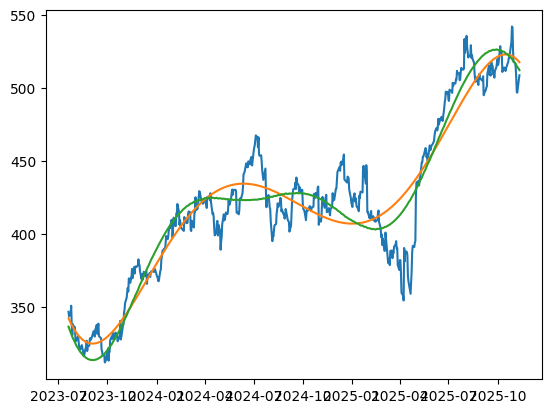

In [99]:
plt.plot(df["MSFT_Close"])
plt.plot(df["Poly_Trend"])
plt.plot(df["Poly_Trend"] + df['seasonal_poly'])

In [100]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['MSFT_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")


Estadístico ADF: -1.317967870355434
p-value: 0.6209124284379931
La tendencia no es estacionaria (aceptamos la hipótesis nula).


CONCLUSIÓN:
Conforme a los gráficos y la prueba ADF se puede confirmar que la serie de los precios de cierre de la marca Microsoft no es estacionaria ya que los precios de cierre van cambiando con el tiempo y siguen una tendencia, lo cual lo podemos observar visualmente en cada uno de los gráficos en los que además realizamos la prueba de las regresiones polinomiales usando diferentes grados para eliminar la tendencia o darle menos peso al ruido pero aún así el gráfico de residuales nos muestran que no son estacionarios en donde la prueba ADF nos lo afirma ya que estos muestran cambios que tienen una estructura lo que nos indica que hay evidencia estadistica de que la serie es no estacionaria.